In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
import os
import datetime
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings('ignore')

animelist = pd.read_csv('AnimeList.csv')

In [9]:
# Menghapus baris yang mengandung nilai null
animelist_cleaned = animelist.dropna()

# Mengisi nilai null dengan nilai tetap (misalnya 0 untuk numerik, 'Unknown' untuk non-numerik)
animelist_filled = animelist.copy()
for column in animelist_filled.columns:
    if animelist_filled[column].dtype == np.number:
        animelist_filled[column] = animelist_filled[column].fillna(0)
    else:
        animelist_filled[column] = animelist_filled[column].fillna('Unknown')

# Mengisi nilai null dengan mean dari kolom numerik
animelist_mean = animelist.copy()
for column in animelist_mean.select_dtypes(include=[np.number]).columns:
    animelist_mean[column] = animelist_mean[column].fillna(animelist_mean[column].mean())


# Menghapus kolom yang seluruhnya berisi nilai NaN
animelist_mean = animelist_mean.dropna(axis=1, how='all')

print(animelist_cleaned.head())
print(animelist_filled.head())
print(animelist_mean.head())

    anime_id                 title  \
0      11013         Inu x Boku SS   
12     11123  Sekaiichi Hatsukoi 2   
18       210               Ranma ½   
19      4224             Toradora!   
25     10800           Chihayafuru   

                                        title_english title_japanese  \
0                           Inu X Boku Secret Service         妖狐×僕SS   
12  Sekai Ichi Hatsukoi - World&#039;s Greatest Fi...        世界一初恋 2   
18                                            Ranma ½         らんま1/2   
19                                          Toradora!          とらドラ！   
25                                        Chihayafuru          ちはやふる   

                                       title_synonyms  \
0                                     Youko x Boku SS   
12  Sekai-ichi Hatsukoi 2, Sekai&#039;ichi Hatsukoi 2   
18                      Ranma 1/2, Ranma ½ Nettou Hen   
19                                     Tiger X Dragon   
25                                        Chihayafull

In [10]:
animelist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14478 entries, 0 to 14477
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        14478 non-null  int64  
 1   title           14478 non-null  object 
 2   title_english   5724 non-null   object 
 3   title_japanese  14443 non-null  object 
 4   title_synonyms  8937 non-null   object 
 5   image_url       14382 non-null  object 
 6   type            14478 non-null  object 
 7   source          14478 non-null  object 
 8   episodes        14478 non-null  int64  
 9   status          14478 non-null  object 
 10  airing          14478 non-null  bool   
 11  aired_string    14478 non-null  object 
 12  aired           14478 non-null  object 
 13  duration        14478 non-null  object 
 14  rating          13934 non-null  object 
 15  score           14478 non-null  float64
 16  scored_by       14478 non-null  int64  
 17  rank            12904 non-null 

In [11]:
animelist.head(5)

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Princess Tutu aired in two parts. The first pa...,Summer 2002,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ..."
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,NaN,Fall 2012,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)..."


In [15]:
animelist.sample(5)

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
10846,32158,Mobile Suit Gundam-san: Bouya Dakara sa,NaN,機動戦士ガンダムさん 坊やだからさ,Kidou Senshi Gundam-san: Because I&#039;m a Boy,https://myanimelist.cdn-dena.com/images/anime/...,Special,4-koma manga,1,Finished Airing,...,The episode was screened on the Wall-G display...,NaN,NaN,"{'Adaptation': [{'mal_id': 15018, 'type': 'man...",NaN,NaN,Sunrise,"Comedy, Mecha, Parody",[],[]
13257,31562,Neko no Dayan: Nihon e Iku,NaN,猫のダヤン 日本へ行く,Dayan the Cat Goes to Japan,https://myanimelist.cdn-dena.com/images/anime/...,TV,Picture book,12,Finished Airing,...,NaN,Fall 2015,Saturdays at 07:00 (JST),"{'Prequel': [{'mal_id': 23555, 'type': 'anime'...",NaN,NaN,Kachidoki Studio,Kids,[],[]
820,2146,Canary,NaN,カナリア,NaN,https://myanimelist.cdn-dena.com/images/anime/...,OVA,Visual novel,1,Finished Airing,...,NaN,NaN,NaN,[],NaN,NaN,SOEISHINSHA,"Fantasy, Music, Romance, School",[],[]
1567,6783,ef: A Tale of Memories. - Recollections,ef ~ A Tale of Melodies - Recollections,ef - a tale of memories. ~Recollections~,NaN,https://myanimelist.cdn-dena.com/images/anime/...,Special,Visual novel,1,Finished Airing,...,NaN,NaN,NaN,"{'Full story': [{'mal_id': 2924, 'type': 'anim...",Rondo Robe,NaN,Shaft,"Mystery, Drama, Romance","['""euphoric field"" by Tenmon feat. ELISA']","['""I&#039;m here"" by Hiroko Taguchi']"
5702,32745,Fake Style,NaN,FAKE STYLE,Fake Type.: Fake Style,https://myanimelist.cdn-dena.com/images/anime/...,Music,Music,1,Finished Airing,...,NaN,NaN,NaN,"{'Sequel': [{'mal_id': 32747, 'type': 'anime',...",Rambling Records,NaN,NaN,Music,[],[]


In [16]:
anime_image_url = animelist[['anime_id', 'title', 'image_url', 'source']]
anime_image_url.sample(10)

,anime_id,title,image_url,source
7828,29705,Shoujo Kyouiku,https://myanimelist.cdn-dena.com/images/anime/...,Visual novel
12316,2692,CB Chara Go Nagai World,https://myanimelist.cdn-dena.com/images/anime/...,Unknown
11221,1821,Guren,https://myanimelist.cdn-dena.com/images/anime/...,Visual novel
99,7791,K-On!!,https://myanimelist.cdn-dena.com/images/anime/...,4-koma manga
5001,36239,Sono Me ga Mitsumeru Mono,https://myanimelist.cdn-dena.com/images/anime/...,Other
2104,32041,Mori no Densetsu: Dai Ni Gakushou,https://myanimelist.cdn-dena.com/images/anime/...,Original
8467,35227,Akita Kenritsu Iburi Gakkou Chuutou-bu: Web-ba...,https://myanimelist.cdn-dena.com/images/anime/...,Original
3031,32871,Kuroko no Basket Movie 3: Winter Cup - Tobira ...,https://myanimelist.cdn-dena.com/images/anime/...,Manga
6583,10259,Da Yu Hai Tang,https://myanimelist.cdn-dena.com/images/anime/...,Original
523,31165,Meiji x Kokosake & anohana Receipt Oubo Campaign,https://myanimelist.cdn-dena.com/images/anime/...,Original


In [17]:
anime_rank = animelist[['anime_id', 'title', 'score', 'rank', 'aired_string', 'favorites', 'licensor', 'studio', 'producer', 'rating']]
anime_rank.sample(5)

,anime_id,title,score,rank,aired_string,favorites,licensor,studio,producer,rating
6751,8689,Born by Myself,3.36,9491.0,2005,0,NaN,NaN,The Village of Marchen,PG-13 - Teens 13 or older
8351,3153,Kagaku Ninja-tai Gatchaman (Movie),6.31,6349.0,"Jul 15, 1978",0,Sentai Filmworks,Tatsunoko Production,"Imagi, Toshiba Entertainment",PG-13 - Teens 13 or older
12006,27663,Baby Steps 2nd Season,8.16,354.0,"Apr 5, 2015 to Sep 20, 2015",244,NaN,Studio Pierrot,NHK,PG-13 - Teens 13 or older
1758,2999,Hi no Tori: Yamato-hen,6.95,3736.0,"Aug 1, 1987",2,NaN,Madhouse,"Kadokawa Shoten, Tezuka Productions, Tohokushi...",PG-13 - Teens 13 or older
13320,2560,Terra e...,6.57,5350.0,"Apr 26, 1980",9,Nozomi Entertainment,Toei Animation,NaN,PG-13 - Teens 13 or older


In [18]:
anime_song = animelist[['anime_id', 'title', 'opening_theme', 'ending_theme']]
anime_song.sample(10)

,anime_id,title,opening_theme,ending_theme
5581,9318,Samero,[],[]
6467,6712,Natsu no Arashi! Akinaichuu,"['""Oyasumi Paradox (おやすみパラドックス)"" by Etsuko Yak...","['#1: ""Otome no Junjo (乙女の順序)"" by Ryoko Shirai..."
12151,4872,Goku Sayonara Zetsubou Sensei,"['#1 ""Kuusou Runba"" by Kenji Otsuki and Zetsub...","['1. ""Marionette"" by ROLLY and Zetsubou Girls ..."
2381,8749,Forestry,[],[]
7223,3051,Yes! Precure 5 Movie: Kagami no Kuni no Miracl...,[],"['""Ganbalance de Dance ~Yume Miru Kisekitachi~..."
8774,30767,Wonder 3 Pilot,[],[]
4474,10934,Itsuka Tenma no Kuro Usagi OVA,"['""Once"" by Hitomi Harada']","['""Sparkling Kiss"" by Iori Nomizu']"
10716,2312,Daishizen no Majuu: Bagi,[],[]
4260,971,Astro Boy: Tetsuwan Atom,"['#1: ""True Blue"" by Zone', '#2: ""Now or Never...","['#1: ""Boy&#039;s Heart"" by Fujii Fumiya', '#2..."
56,7518,Boku wa Kuma,[],[]


In [19]:
anime_rank50 = animelist[animelist.popularity!=0].sort_values(by='rank').head(50).loc[:,['popularity', 'rank', 'title', 'type', 'source', 'scored_by', 'favorites', 'score']]
popularity_and_rank50 = anime_rank50[(anime_rank50.popularity <= 100)]
popularity_and_rank50["point"] = (popularity_and_rank50["scored_by"] * popularity_and_rank50["favorites"] * popularity_and_rank50["score"])/10000000000
popularity_and_rank50

,popularity,rank,title,type,source,scored_by,favorites,score,point
2555,4,1.0,Fullmetal Alchemist: Brotherhood,TV,Manga,733592,106895,9.25,72.536018
1028,33,2.0,Kimi no Na wa.,Movie,Original,471398,34912,9.19,15.124394
2999,8,5.0,Steins;Gate,TV,Visual novel,563857,92423,9.14,47.631607
418,35,8.0,Hunter x Hunter (2011),TV,Manga,403377,64375,9.11,23.656296
6572,77,12.0,Koe no Katachi,Movie,Manga,296261,19815,9.04,5.306852
2783,55,14.0,Clannad: After Story,TV,Visual novel,363239,47380,9.01,15.506448
6553,95,15.0,Gintama,TV,Manga,141830,33781,9.01,4.316834
7403,22,18.0,Code Geass: Hangyaku no Lelouch R2,TV,Original,543904,44230,8.95,21.530902
7105,39,19.0,Sen to Chihiro no Kamikakushi,Movie,Original,498602,15412,8.92,6.854533
11640,37,21.0,Shigatsu wa Kimi no Uso,TV,Manga,413527,39664,8.88,14.565096


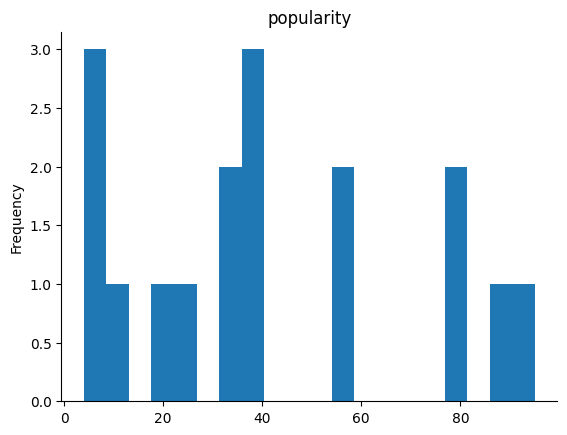

In [20]:


popularity_and_rank50['popularity'].plot(kind='hist', bins=20, title='popularity')
plt.gca().spines[['top', 'right',]].set_visible(False)

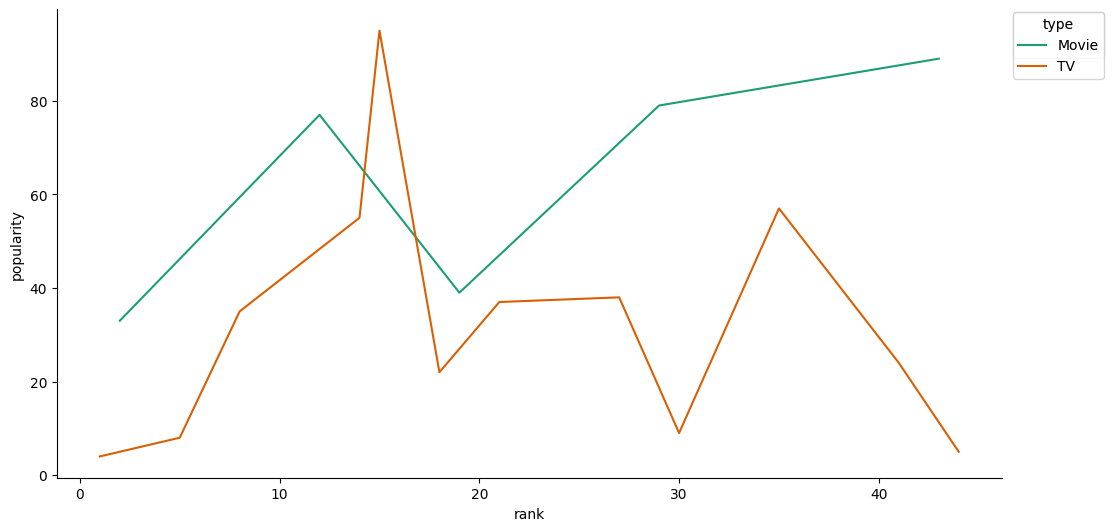

In [22]:
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['rank']
  ys = series['popularity']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = popularity_and_rank50.sort_values('rank', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('type')):
  _plot_series(series, series_name, i)
  fig.legend(title='type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('rank')
_ = plt.ylabel('popularity')

In [23]:
df_title = popularity_and_rank50['title'].astype("str").tolist()
df_point  = popularity_and_rank50['point'].astype("int32").tolist()

list_popularity_and_rank50 = []

for i in range(0, len(df_point)):
    for j in range(0, df_point[i]):
        list_popularity_and_rank50.append(df_title[i])

list_popularity_and_rank50[-10:]

['One Punch Man',
 'One Punch Man',
 'One Punch Man',
 'One Punch Man',
 'One Punch Man',
 'One Punch Man',
 'One Punch Man',
 'One Punch Man',
 'One Punch Man',
 'One Punch Man']

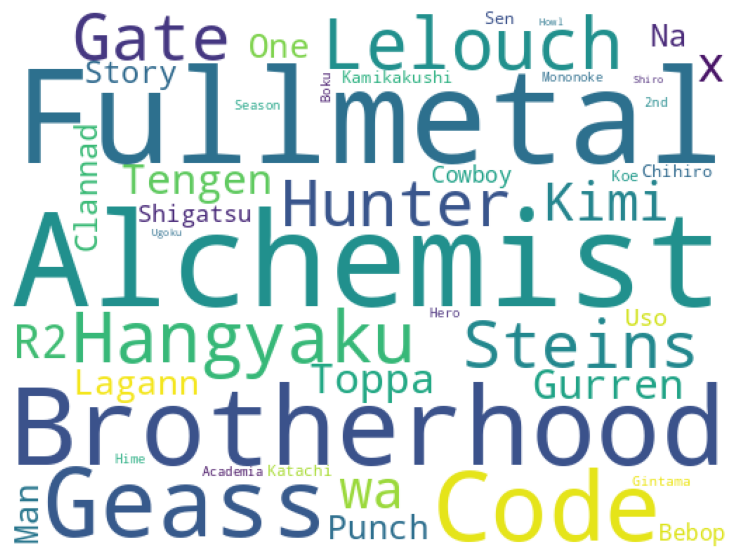

In [24]:
plt.subplots(figsize=(14,7))
wordcloud = WordCloud(    collocations=False,
                          background_color='white',
                          width=512,
                          height=384
                         ).generate(" ".join(list_popularity_and_rank50))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [25]:
anime_sorted_by_pop = animelist[animelist.popularity!=0].sort_values(by='popularity').head(50).loc[:,['title','popularity','rank']]
anime_sorted_by_pop.head()

,title,popularity,rank
7913,Death Note,1,51.0
8123,Shingeki no Kyojin,2,110.0
6296,Sword Art Online,3,1259.0
2555,Fullmetal Alchemist: Brotherhood,4,1.0
8863,One Punch Man,5,44.0


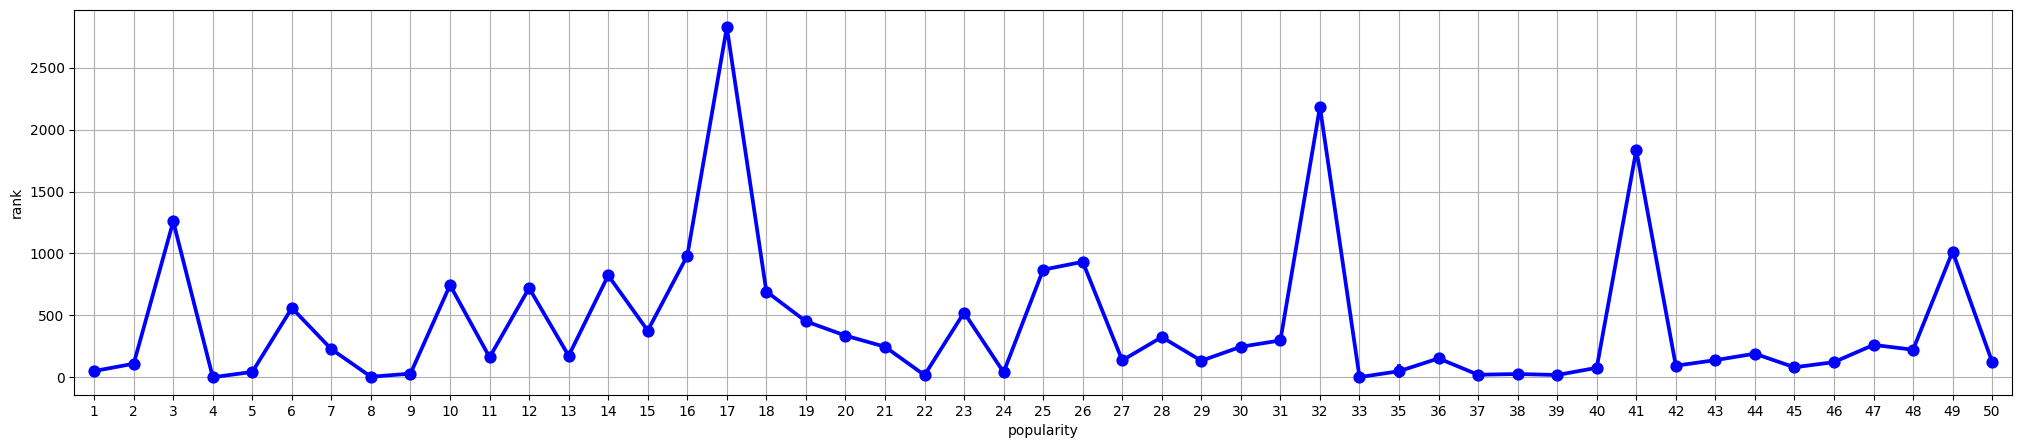

In [26]:
f,ax1 = plt.subplots(figsize =(25,5))
sns.pointplot(x='popularity',y='rank',data=anime_sorted_by_pop,color='blue')
plt.grid()

In [50]:
anime_sorted_by_pop[anime_sorted_by_pop["popularity"]==12]

,title,popularity,rank
9176,Mirai Nikki (TV),12,721.0


In [28]:
animelist['genre'] = animelist['genre'].fillna('')
animelist_genre = animelist.genre
animelist_genre.head()

0      Comedy, Supernatural, Romance, Shounen
1    Comedy, Parody, Romance, School, Shounen
2               Comedy, Magic, School, Shoujo
3      Comedy, Drama, Magic, Romance, Fantasy
4             Comedy, Drama, Romance, Shounen
Name: genre, dtype: object

In [29]:
genre_list = []
genre_splited = []

for i in animelist_genre.index:
    for j in animelist_genre[i].split(", "):
        genre_splited.append(j)
        if j not in genre_list:
            genre_list.append(j)

print(genre_list[:10])
print(genre_splited[:10])

['Comedy', 'Supernatural', 'Romance', 'Shounen', 'Parody', 'School', 'Magic', 'Shoujo', 'Drama', 'Fantasy']
['Comedy', 'Supernatural', 'Romance', 'Shounen', 'Comedy', 'Parody', 'Romance', 'School', 'Shounen', 'Comedy']


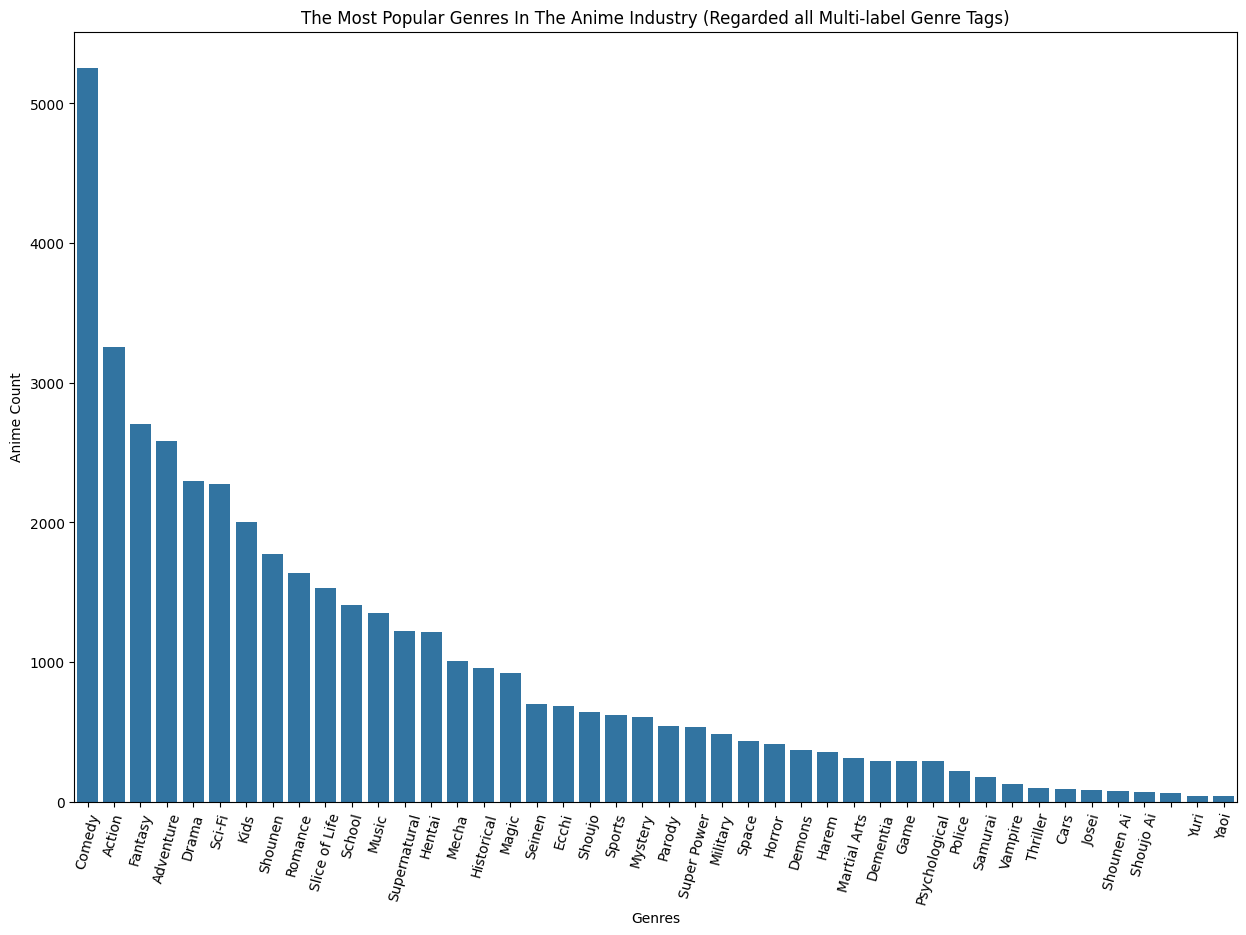

In [30]:
animelist_genres_count = pd.Series(genre_splited).value_counts()

plt.figure(figsize=(15,10))
sns.barplot(x=animelist_genres_count.index.tolist(), y=animelist_genres_count.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('The Most Popular Genres In The Anime Industry (Regarded all Multi-label Genre Tags)')
plt.xticks(rotation= 75)
plt.show()

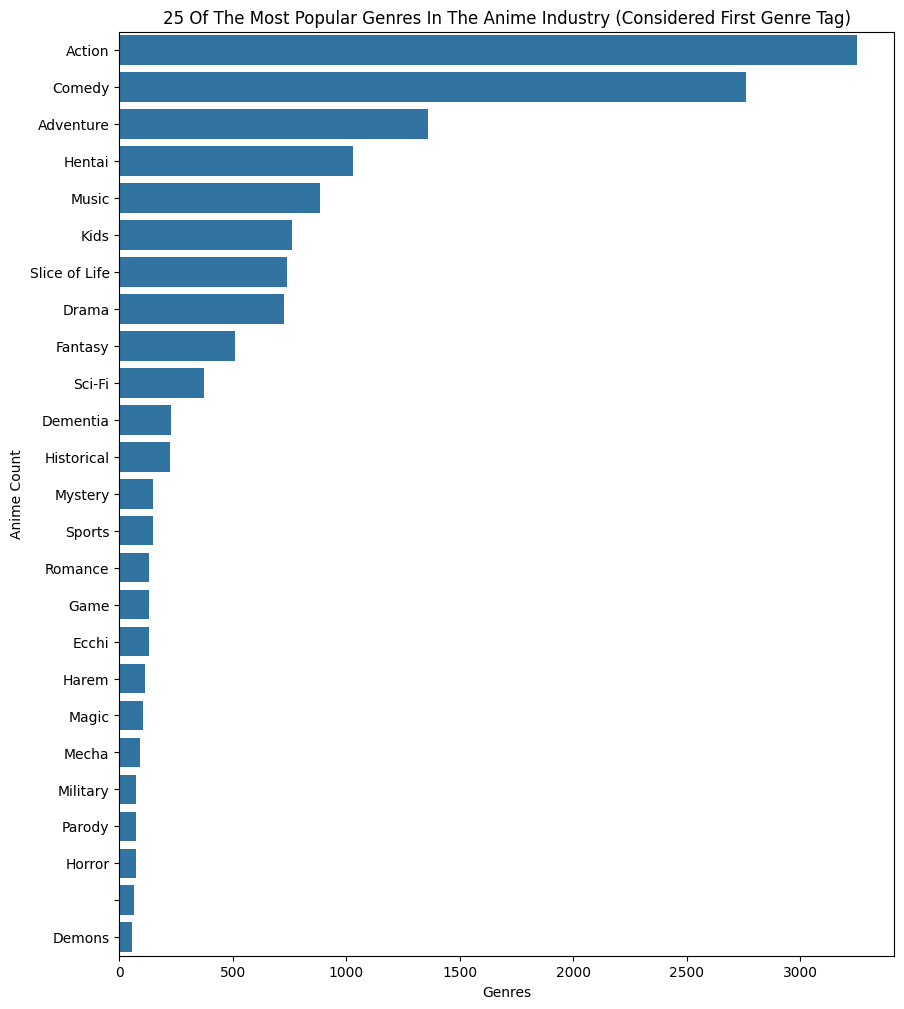

In [31]:
genre_firsts = []

for i in animelist_genre.index:
    genre_firsts.append(animelist_genre[i].split(", ")[0])

anime_genres_firsts = pd.Series(genre_firsts).value_counts()

plt.figure(figsize=(10,12))
sns.barplot(x=anime_genres_firsts[0:25].tolist(), y=anime_genres_firsts[0:25].index.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('25 Of The Most Popular Genres In The Anime Industry (Considered First Genre Tag)')
plt.show()

In [32]:
genre_one_label = []

for i in animelist_genre.index:
    if len(animelist_genre[i].split(", ")) == 1:
        genre_one_label.append(animelist_genre[i])

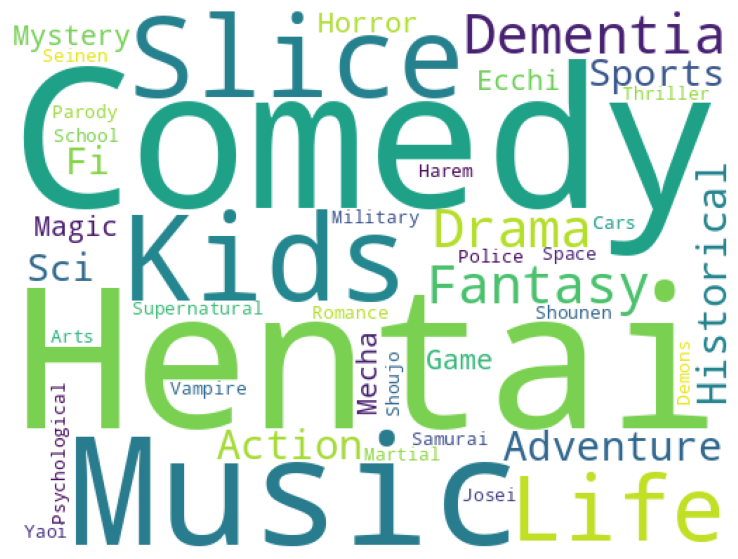

In [33]:
anime_genres_one_label_count = pd.Series(genre_one_label).value_counts()

plt.subplots(figsize=(14,7))
wordcloud = WordCloud(background_color='white', width=512,height=384).generate(" ".join(anime_genres_one_label_count.index.tolist()))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [34]:
animelist = animelist.dropna(subset=['genre'])
animelist['genre'] = animelist['genre'].fillna('Unknown')
animelist['is_music'] = animelist['genre'].apply(lambda x: 1 if 'Music' in x else 0)

X = animelist[['episodes', 'score']].fillna(0)
y = animelist['is_music']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [37]:
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

[[2611   25]
 [ 250   10]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      2636
           1       0.29      0.04      0.07       260

    accuracy                           0.91      2896
   macro avg       0.60      0.51      0.51      2896
weighted avg       0.86      0.91      0.87      2896

Accuracy: 0.9050414364640884


In [38]:
animelist = animelist.dropna(subset=['genre', 'title'])
animelist['genre'] = animelist['genre'].fillna('Unknown')
animelist['is_action'] = animelist['genre'].apply(lambda x: 1 if 'Action' in x else 0)

X = animelist['title']
y = animelist['is_action']

In [39]:
vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.1, random_state=100)

In [41]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [42]:
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

[[1136   18]
 [ 226   68]]
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1154
           1       0.79      0.23      0.36       294

    accuracy                           0.83      1448
   macro avg       0.81      0.61      0.63      1448
weighted avg       0.83      0.83      0.79      1448

Accuracy: 0.8314917127071824


In [51]:
def main(file_path, n_neighbors=5):
    """Main function to preprocess data, train the model, and test new titles."""
    data = preprocess_data(file_path)

    knn_model, vectorizer = train_knn_model(data, n_neighbors)

    while True:
        user_input = input("Ketik judul anime atau ketik selesai jika ingin mengakhiri: ")

        if user_input.lower() == 'selesai':
            break

        test_titles = [user_input]

        # Test the KNN model with user input
        predictions = test_knn_model(knn_model, vectorizer, test_titles)

        # Display test results
        for title, prediction in zip(test_titles, predictions):
            print(f"Title: {title} -> Genre: {prediction}")

# Path to the dataset (replace with actual path to your AnimeList CSV file)
file_path = 'AnimeList.csv'

# Run the main function
main(file_path)

Ketik judul anime atau ketik selesai jika ingin mengakhiri: Bang Dream 
Title: Bang Dream  -> Genre: Music
Ketik judul anime atau ketik selesai jika ingin mengakhiri: Love live
Title: Love live -> Genre: Music, School, Slice of Life
Ketik judul anime atau ketik selesai jika ingin mengakhiri: Naruto
Title: Naruto -> Genre: Action, Adventure, Comedy, Super Power, Martial Arts, Shounen
Ketik judul anime atau ketik selesai jika ingin mengakhiri: Doraemon
Title: Doraemon -> Genre: Adventure, Comedy, Fantasy, Kids, Shounen
Ketik judul anime atau ketik selesai jika ingin mengakhiri: Bakuman
Title: Bakuman -> Genre: Comedy, Drama, Romance, Shounen
Ketik judul anime atau ketik selesai jika ingin mengakhiri: Noragami
Title: Noragami -> Genre: Action, Adventure, Comedy, Supernatural, Shounen
Ketik judul anime atau ketik selesai jika ingin mengakhiri: selesai
